# 任务1

In [183]:
import sys
sys.path.append("C:\\Users\\11234\\Desktop\\MLChem\\Github\\Mechine-Learning-and-its-Applications-in-Chemistry\\Labs\\Lab1")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nci_birman = pd.read_csv("nci_birman.csv", sep='\t')


In [184]:
from typing import Tuple
import numpy as np

R = 8.314    # ideal gas constant
kcal_to_kj = 4.184    # unit conversion

def prepare_data(in_df: pd.DataFrame, temperature: float=298.0) -> Tuple[pd.DataFrame, pd.Series]:

    def weight_calculate(E1: pd.DataFrame, E2: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        c1 = np.exp(-E1 * 1000 * kcal_to_kj / (R * temperature))
        c2 = np.exp(-E2 * 1000 * kcal_to_kj / (R * temperature))
        w1 = c1 / (c1 + c2)
        w2 = c2 / (c1 + c2)
        return w1, w2
    
    def DDG_calculate(df_er: pd.DataFrame) -> pd.Series:
        ddG = -0.001 * R * temperature * np.log(df_er/100) / kcal_to_kj
        return ddG

    df_de = in_df.iloc[:, :4]
    df_sterimol = in_df.iloc[:, 4:-1]
    df_er = in_df.iloc[:, -1]

    w1, w2 = weight_calculate(df_de.iloc[:, 2], df_de.iloc[:, 3])

    d_pi_w = df_de.iloc[:, 0] * w1 + df_de.iloc[:, 1] * w2
    d_pi_w.name = 'd_pi_w'
    e_pi_w = df_de.iloc[:, 2] * w1 + df_de.iloc[:, 3] * w2
    e_pi_w.name = 'e_pi_w'
    de_pi_w = d_pi_w * e_pi_w
    de_pi_w.name = 'de_pi_w'

    df = pd.concat([d_pi_w, e_pi_w, de_pi_w, df_sterimol], axis=1)

    delta_delta_G = DDG_calculate(df_er)
    delta_delta_G.name = 'delta_delta_G'

    return df, delta_delta_G

In [185]:
X, y_true = prepare_data(nci_birman)
X.iloc[:5, :], y_true[:5]

(   d_pi_w  e_pi_w  de_pi_w  L_Alk  B1_Alk  B5_Alk  L_Ar  B1_Ar  B5_Ar
 0    3.54  -10.24 -36.2496   4.36    2.92    3.35  6.38   1.77   3.15
 1    3.54  -10.24 -36.2496   4.35    2.09    3.34  6.38   1.77   3.15
 2    3.54  -10.24 -36.2496   4.38    1.73    3.33  6.38   1.77   3.15
 3    3.54  -10.24 -36.2496   3.08    1.70    2.20  6.38   1.77   3.15
 4    3.49  -11.88 -41.4612   3.08    1.70    2.20  6.38   1.88   4.52,
 0    2.409283
 1    2.009314
 2    1.939568
 3    1.770392
 4    1.770392
 Name: delta_delta_G, dtype: float64)

## 测试

In [186]:
### CAUTION: DO NOT MODIFY THIS CELL. ###

test_in_df = pd.concat([
    pd.DataFrame({
        "d_pi_d": [4.89, 4.91, 6.48, 7.00],
        "d_pi_D": [7.00, 7.21, 7.22, 7.20],
        "e_pi_d": [-3.48, -2.98, -1.80, -1.45],
        "e_pi_D": [-1.48, -2.00, -1.96, -2.26]
    }),
    nci_birman.iloc[:4, 4:]
], axis=1)

test_labels = np.array([2.409283, 2.009314, 1.939568, 1.770392])
test_weighted_features = np.array([
    [4.959643, -3.413988, -16.932160],
    [5.279007, -2.822771, -14.901427],
    [6.899685, -1.890743, -13.045529],
    [7.159408, -2.095601, -15.003264]
])

def test_prepare_data_names(in_df):
    X_, y_true_ = prepare_data(in_df)
    assert set(X.columns) == {"d_pi_w", "e_pi_w", "de_pi_w", "L_Alk", "B1_Alk", "B5_Alk", "L_Ar", "B1_Ar", "B5_Ar"}, "wrong column names."
    assert y_true_.name == "delta_delta_G", "wrong label name."

def test_prepare_data_labels(in_df, labels):
    _, y_true_ = prepare_data(in_df)
    np.testing.assert_allclose(
        y_true_, labels, rtol=1.0e-3,
        err_msg="wrong label values."
    )

def test_prepare_data_weighted_features(in_df, weighted_features):
    X_, _ = prepare_data(in_df)
    np.testing.assert_allclose(
        X_.loc[:, ["d_pi_w", "e_pi_w", "de_pi_w"]], weighted_features, rtol=1.0e-3,
        err_msg="wrong weighted feature values."
    )
    
try:
    test_prepare_data_names(test_in_df)
    print("names: PASSED")
except Exception as err:
    print(err)

try:
    test_prepare_data_labels(test_in_df, test_labels)
    print("labels: PASSED")
except Exception as err:
    print(err)

try:
    test_prepare_data_weighted_features(test_in_df, test_weighted_features)
    print("weighted features: PASSED")
except Exception as err:
    print(err)

names: PASSED
labels: PASSED
weighted features: PASSED


# 任务2
# 任务2.1

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_and_normalize(
    X: pd.DataFrame, y_true: pd.Series, test_size: int=5
) -> Tuple[np.array, np.array, np.array, np.array]:

    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=test_size)
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) 
    # 此处使用修改后的计算方法，即使用训练集的scaler计算测试集的方差，故检验代码中会显示错误
    
    return X_train_scaled, X_test_scaled, y_train, y_test


In [188]:
X_train, X_test, y_true_train, y_true_test = split_and_normalize(X, y_true)

### 测试

In [189]:
n_samples, n_features, test_size = 40, 9, 7
test_X = np.random.randn(n_samples, n_features)
test_y_true = np.random.randn(n_samples)

def test_split_and_normalize_shapes(X, y_true):
    X_train_, X_test_, y_true_train_, y_true_test_ = split_and_normalize(X, y_true, test_size=test_size)
    assert (X_train_.shape, X_test_.shape) == ((n_samples - test_size, 9), (test_size, 9)), "wrong X shape."
    assert (*y_true_train_.shape, *y_true_test_.shape) == (n_samples - test_size, test_size), "wrong y_true shape."

def test_split_and_normalize_normalized(X, y_true):
    X_train_, X_test_, _, _ = split_and_normalize(X, y_true)
    np.testing.assert_allclose(
        X_train_.mean(axis=0), np.zeros(n_features), atol=1.0e-5,
        err_msg="invalid X_train normalization: non-zero mean."
    )
    np.testing.assert_allclose(
        X_test_.mean(axis=0), np.zeros(n_features), atol=1.0e-5,
        err_msg="invalid X_test normalization: non-zero mean."
    )
    np.testing.assert_allclose(
        X_train_.std(axis=0), np.ones(n_features), rtol=1.0e-3,
        err_msg="invalid X_train normalization: non-unit std."
    )
    np.testing.assert_allclose(
        X_test_.std(axis=0), np.ones(n_features), rtol=1.0e-3,
        err_msg="invalid X_test normalization: non-unit std."
    )

try:
    test_split_and_normalize_shapes(test_X, test_y_true)
    print("shapes after split: PASSED")
except Exception as err:
    print(err)

try:
    test_split_and_normalize_normalized(test_X, test_y_true)
    print("normalization: PASSED")
except Exception as err:
    print(err)

shapes after split: PASSED

Not equal to tolerance rtol=1e-07, atol=1e-05
invalid X_test normalization: non-zero mean.
Mismatched elements: 9 / 9 (100%)
Max absolute difference: 0.94055688
Max relative difference: inf
 x: array([ 0.140152,  0.051021,  0.845077, -0.940557, -0.226614, -0.796224,
       -0.491826, -0.176586,  0.895528])
 y: array([0., 0., 0., 0., 0., 0., 0., 0., 0.])


## 任务2.2

在机器学习中，均值-方差归一化（常被称为标准化或z-score归一化）需要在训练集和测试集上分开进行，主要基于以下几点考虑：

1. **信息泄露**：如果你在拆分数据集之前进行归一化，那么测试集的信息就被用于了训练集的归一化计算，从而导致了训练集和测试集之间的信息泄露。在现实场景中，测试集应当模拟未来的、未知的数据，因此在模型训练阶段，你不应当有关于测试集的任何信息。

2. **模拟实际情境**：在真实应用中，当你有了新的数据并希望使用模型进行预测时，你不可能知道整个数据集的均值和标准差。因此，使用训练集的均值和标准差来标准化测试数据更能模拟真实的使用情境。

3. **保持评估的公正性**：如果测试数据参与了训练数据的归一化计算，那么在评估模型时可能会获得一个不真实、过于乐观的评估结果。这是因为模型可能间接地“看到”了测试数据。

如果你先进行归一化再进行数据拆分，可能会导致以下后果：

1. **评估偏差**：如上所述，这样的做法可能会导致模型的评估结果过于乐观。
  
2. **模型泛化能力下降**：由于模型训练过程中间接地使用了测试集的信息，所以它可能在训练集上表现得很好，但在其他未知数据上的表现就可能不尽如人意。

3. **不稳定的归一化参数**：如果经常使用新数据进行模型评估，每次使用整个数据集的均值和标准差进行归一化可能会导致归一化参数的不稳定，进而影响模型的稳定性。

总之，为了防止信息泄露和确保模型评估的准确性，最好在拆分数据集之后再进行归一化，并且只使用训练集的均值和标准差来标准化测试集。

# 任务3
## 任务3.1

In [190]:
from sklearn.linear_model import LinearRegression

def train_model(X_train, y_true_train) -> object:
    model = LinearRegression()
    model.fit(X_train, y_true_train)
    return model

In [191]:
lr = train_model(X_train, y_true_train)

## 任务3.2

In [192]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

def plot_prediction(y_true: np.array, y_pred: np.array):
    r2 = r2_score(y_true, y_pred)
    # text annotation setup
    plt.title(r"True values vs predicted values ($R^2$ = " + f"{r2:.4f}" + ")")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    # plot the scatter and line
    plt.scatter(y_true, y_pred, c="red", marker="o")
    plt.plot(y_true, y_true, "b--")
    # show the plot!
    plt.show()

def evaluate_model(model, X, y_true, mode: str):
    y_pred = model.predict(X)
    if mode == "plot":
        plot_prediction(y_true, y_pred)
    elif mode == "metrics":
        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred)
        return rmse, r2
    else:
        raise ValueError("invalid mode.")
    
def evaluate(model, X_train, y_true_train, X_test, y_true_test):
    evaluate_model(model, X_train, y_true_train, mode="plot")
    RMSE, r2 = evaluate_model(model, X_test, y_true_test, mode="metrics")
    print(f"RMSE: {RMSE}")
    print(f"r2: {r2}")
    evaluate_model(model, X_test, y_true_test, mode="plot")

## 任务3.3

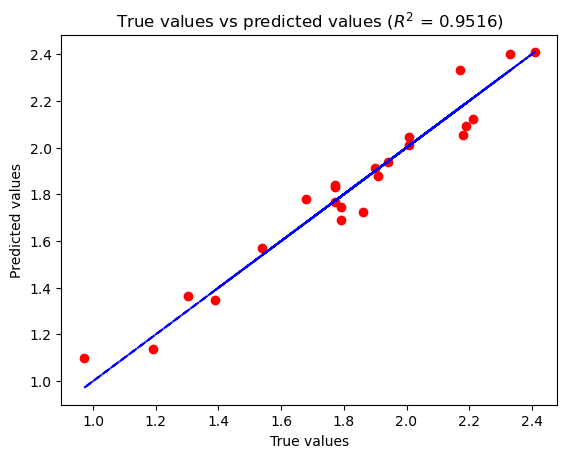

RMSE: 0.021064511755857267
r2: 0.8332196828793584


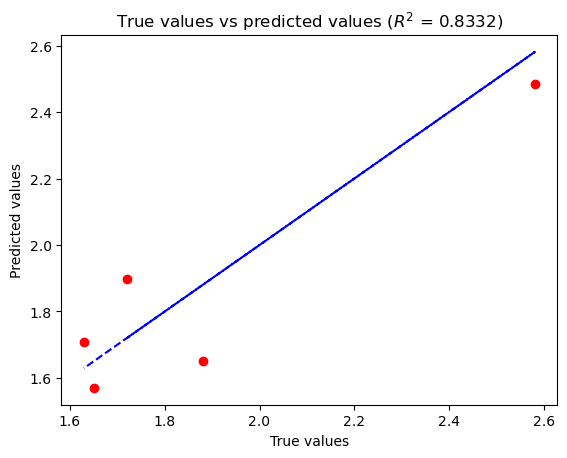

In [193]:
lr = train_model(X_train, y_true_train)
evaluate(lr, X_train, y_true_train, X_test, y_true_test)

# 选做任务

## K-Fold Cross Validation and Leave-One-Out Cross Validation
- 考虑使用k-折交叉验证对原有数据集进行划分，然后对每一折数据进行训练和测试，最后取平均值作为最终的模型评估结果。
- 此处为了与之前的计算保持一致，令 $k=7$
- 进行Loo交叉验证，即令 $k=n$，其中 $n$ 为数据集的大小。

In [194]:
from sklearn.model_selection import KFold, LeaveOneOut
from typing import Generator

def split_and_normalize_kfold(
    X, y_true: pd.Series, n_splits: int = 7
) -> Generator:

    kf = KFold(n_splits=n_splits)
    scaler = StandardScaler()

    for train_idx, test_idx in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        elif isinstance(X, np.ndarray):
            X_train, X_test = X[train_idx], X[test_idx]
        else:
            raise TypeError("invalid X type.")
        y_train, y_test = y_true.iloc[train_idx], y_true.iloc[test_idx]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        yield X_train_scaled, X_test_scaled, y_train, y_test

def split_and_normalize_loo(X, y_true: pd.Series) -> Generator:

    loo = LeaveOneOut()
    scaler = StandardScaler()

    for train_idx, test_idx in loo.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        elif isinstance(X, np.ndarray):
            X_train, X_test = X[train_idx], X[test_idx]
        else:
            raise TypeError("invalid X type.")
        y_train, y_test = y_true.iloc[train_idx], y_true.iloc[test_idx]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        yield X_train_scaled, X_test_scaled, y_train, y_test


## PCA 分析

In [195]:
from sklearn.decomposition import PCA
import pandas as pd


n_splits = 5
results = []

for i in range(1, 10):
    total_rmse_train, total_r2_train = 0, 0
    total_rmse_test, total_r2_test = 0, 0
    counter = 0

    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)

    for X_train_pca, X_test_pca, y_true_train_pca, y_true_test_pca in split_and_normalize_kfold(X_pca, y_true):
        lr_pca = train_model(X_train_pca, y_true_train_pca)
        rmse_train, r2_train = evaluate_model(lr_pca, X_train_pca, y_true_train_pca, mode="metrics")
        rmse_test, r2_test = evaluate_model(lr_pca, X_test_pca, y_true_test_pca, mode="metrics")
        total_rmse_train += rmse_train
        total_r2_train += r2_train
        total_rmse_test += rmse_test
        total_r2_test += r2_test
        counter += 1

    avg_rmse_train = total_rmse_train / counter
    avg_r2_train = total_r2_train / counter
    avg_rmse_test = total_rmse_test / counter
    avg_r2_test = total_r2_test / counter
    
    Data = {
            'n_components': i,
            'rmse_train': avg_rmse_train,
            'r2_train': avg_r2_train,
            'rmse_test': avg_rmse_test,
            'r2_test': avg_r2_test
        }
    
    results.append(pd.DataFrame(Data, index=[i]))

results = pd.concat(results)

results

,n_components,rmse_train,r2_train,rmse_test,r2_test
1,1,0.122886,0.023275,0.195818,-4.184116
2,2,0.062744,0.495968,0.118786,-3.800208
3,3,0.044933,0.639754,0.102192,-1.902132
4,4,0.044750,0.641227,0.103392,-1.974769
5,5,0.017052,0.862316,0.037835,-1.074308
6,6,0.009415,0.924404,0.029450,-0.688026
7,7,0.009219,0.926040,0.032789,-0.956492
8,8,0.007381,0.940161,0.037355,-1.106165
9,9,0.007126,0.942335,0.039103,-1.227072


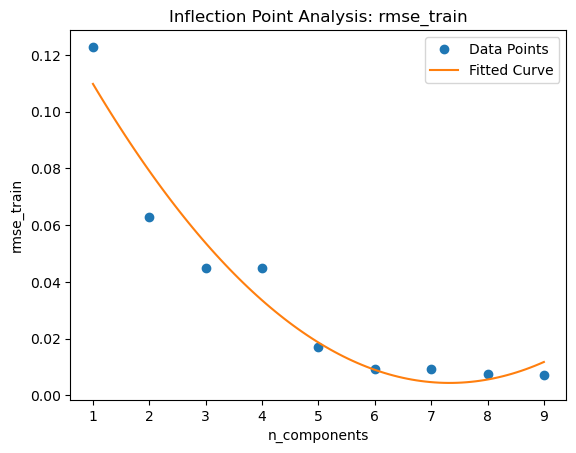

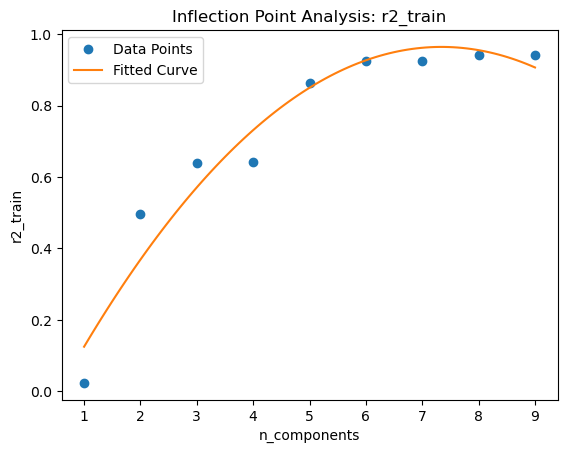

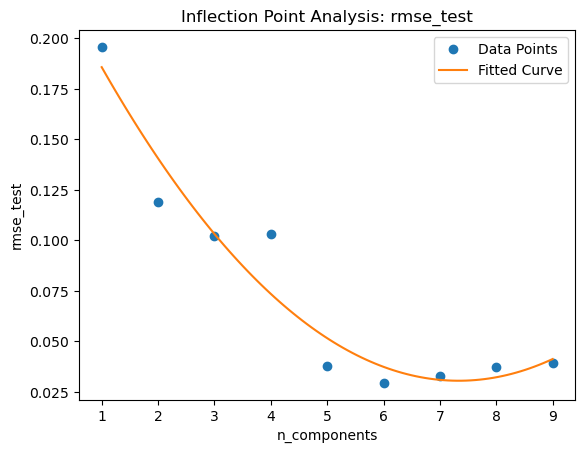

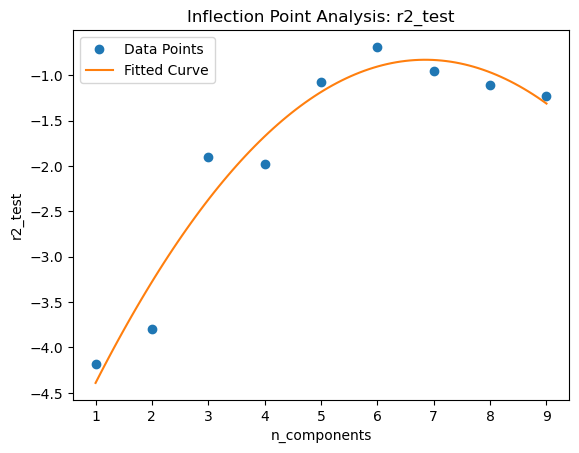

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


for column in results.columns[1:]:
    coefficients = np.polyfit(results['n_components'], results[column], 2)
    
    x = np.linspace(1, 9, 100)
    y = np.polyval(coefficients, x)

    plt.figure()
    plt.plot(results['n_components'], results[column], 'o', label='Data Points')
    plt.plot(x, y, '-', label='Fitted Curve')

    plt.xlabel('n_components')
    plt.ylabel(column)
    plt.title(f"Inflection Point Analysis: {column}")
    plt.legend()
    plt.show()

根据以上信息，不难发现 PCA 中 $n=5/6$ 时拟合效果最佳

# Lasson & Ridge & ElasticNet

In [197]:
# X_train, X_test, y_true_train, y_true_test

from sklearn.linear_model import Ridge, Lasso, ElasticNet

def train_model_LR(X, y_true, alpha: float=1.0, model_type: str="ridge") -> object:
    if model_type == "ridge":
        coefficients = []
        for X_train_pca, X_test_pca, y_true_train_pca, y_true_test_pca in split_and_normalize_loo(X, y_true):
            model = Ridge(alpha=alpha)
            model.fit(X_train_pca, y_true_train_pca)
            coefficients.append(model.coef_)

        avg_coef = np.mean(coefficients, axis=0)
        avg_model = Ridge(alpha=alpha)
        avg_model.coef_ = avg_coef
        avg_model.intercept_ = np.array([0])
        return avg_model
    
    elif model_type == "lasso":
        coefficients = []
        for X_train_pca, X_test_pca, y_true_train_pca, y_true_test_pca in split_and_normalize_loo(X, y_true):
            model = Lasso(alpha=alpha)
            model.fit(X_train_pca, y_true_train_pca)
            coefficients.append(model.coef_)

        avg_coef = np.mean(coefficients, axis=0)
        avg_model = Ridge(alpha=alpha)
        avg_model.coef_ = avg_coef
        avg_model.intercept_ = np.array([0])
        return avg_model
    
    elif model_type == "elasticnet":
        coefficients = []
        for X_train_pca, X_test_pca, y_true_train_pca, y_true_test_pca in split_and_normalize_loo(X, y_true):
            model = ElasticNet(alpha=alpha)
            model.fit(X_train_pca, y_true_train_pca)
            coefficients.append(model.coef_)

        avg_coef = np.mean(coefficients, axis=0)
        avg_model = Ridge(alpha=alpha)
        avg_model.coef_ = avg_coef
        avg_model.intercept_ = np.array([0])
        return avg_model
    
    else:
        raise ValueError("invalid model type.")

def print_coef(name_str, coefs, names=None, sort=False):
    if names.all == None:
        names = ["X%s" % x for x in range(len(coefs))]
    if sort:
        l = zip(coefs, names)
        l = sorted(l, key=lambda x: -np.abs(x[0]))
        coefs, names = zip(*l)
    print(name_str)
    print(" + ".join("%s * %s" % (round(coef, 5), name)
                     for coef, name in zip(coefs, names)))


In [198]:
ridge = train_model_LR(X, y_true, alpha=10, model_type="ridge")
lasso = train_model_LR(X, y_true, alpha=.06, model_type="lasso")
elasticnet = train_model_LR(X, y_true, alpha=.1, model_type="elasticnet")

print_coef('Ridge:', ridge.coef_, names=X.columns)
print_coef('Lasso:', lasso.coef_, names=X.columns)
print_coef('ElasticNet:', elasticnet.coef_, names=X.columns)

Ridge:
-0.1515 * d_pi_w + -0.05691 * e_pi_w + -0.02854 * de_pi_w + 0.01717 * L_Alk + 0.09368 * B1_Alk + 0.01751 * B5_Alk + -0.06139 * L_Ar + -0.02078 * B1_Ar + -0.09406 * B5_Ar
Lasso:
-0.19898 * d_pi_w + 0.0 * e_pi_w + 0.0 * de_pi_w + 0.0 * L_Alk + 0.08524 * B1_Alk + 0.0 * B5_Alk + -0.01273 * L_Ar + 0.0 * B1_Ar + -0.05696 * B5_Ar
ElasticNet:
-0.19613 * d_pi_w + 0.0 * e_pi_w + 0.0 * de_pi_w + 0.0 * L_Alk + 0.08823 * B1_Alk + 0.0 * B5_Alk + -0.02086 * L_Ar + -0.0002 * B1_Ar + -0.05897 * B5_Ar


我们发现，通过L2岭回归难以通过惩罚实现特征的降维，而L1 Lasso回归可以轻易地实现特征的降维，结合L1与L2的ElasticNet回归可以实现与Lasso回归类似的效果。

接下来，我们观察随着ElasticNet回归的$\aplha$值的增大，各个特征的系数如何变化。

In [229]:
def coef_name(coef, name):
    output = {}
    for i in range(len(coef)):
        output[name[i]] = coef[i]
    return output

coefs = pd.DataFrame(columns=['aplha']+list(X.columns))

for _ in range(100):
    # 取对数 log10(_)
    alpha = np.exp(- _/20)
    elasticnet_alpha = train_model_LR(X, y_true, alpha=alpha, model_type="elasticnet")
    data = {'aplha':round(alpha, 3)}
    data.update(coef_name(elasticnet_alpha.coef_, X.columns))
    # 将data加入coef(dataframe)中
    coefs.loc[len(coefs)] = data
    
coefs.iloc[:5, :]


,aplha,d_pi_w,e_pi_w,de_pi_w,L_Alk,B1_Alk,B5_Alk,L_Ar,B1_Ar,B5_Ar
0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


作图

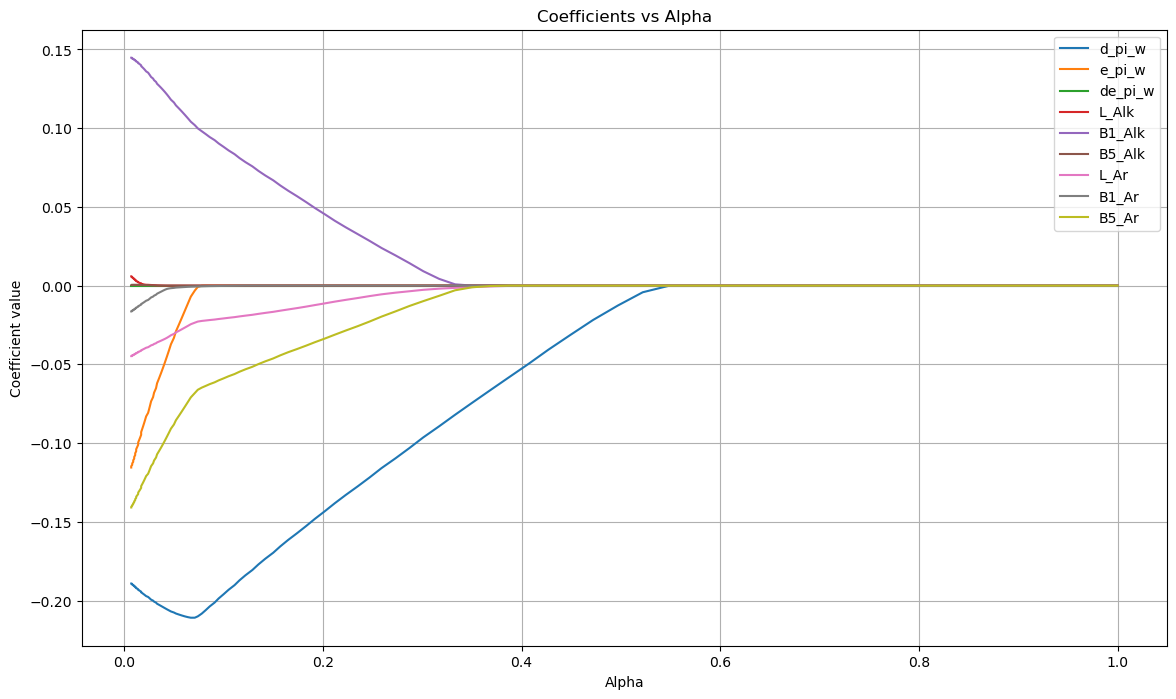

In [230]:
import matplotlib.pyplot as plt

# 假设coefs是您提供的数据框
alphas = coefs['aplha'].values

plt.figure(figsize=(14, 8))

# 对于每一列除了'aplha'，我们都进行绘图
for column in coefs.columns:
    if column != 'aplha':
        plt.plot(alphas, coefs[column], label=column)

plt.title('Coefficients vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Coefficient value')
plt.legend()
plt.grid(True)
plt.show()


# 特征选择

## 方差

In [238]:
from sklearn.feature_selection import VarianceThreshold

def select_features(X: pd.DataFrame, threshold: float=0.0) -> pd.DataFrame:
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X)
    # 输出选出列的名称
    selected_features = X.columns[selector.get_support()].tolist()
    return selected_features

threshold = 0.1
X_variance_selected_feature = select_features(X, threshold=threshold)
print(X_variance_selected_feature)

['e_pi_w', 'de_pi_w', 'L_Alk', 'B1_Alk', 'B5_Alk', 'L_Ar', 'B5_Ar']


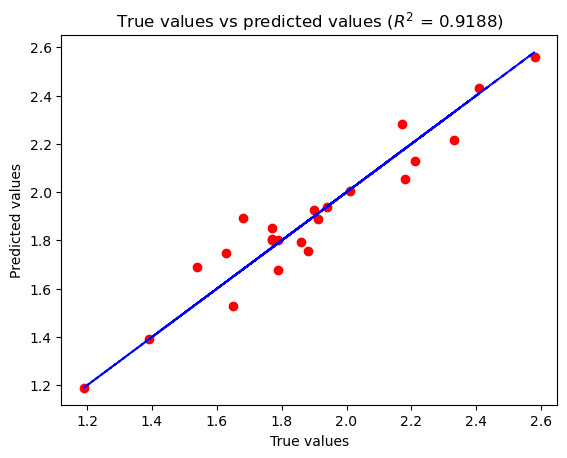

RMSE: 0.030197781719379903
r2: 0.8499409991187117


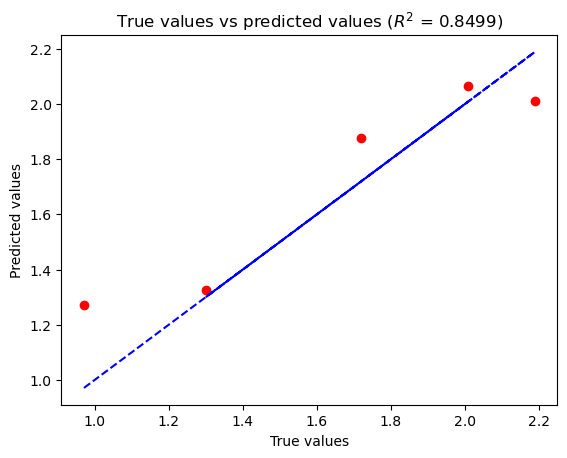

In [242]:
X_variance_selected = X[X_variance_selected_feature]

X_train_variance_selected, X_test_variance_selected, y_true_train, y_true_test = split_and_normalize(X_variance_selected, y_true)

lr_variance = train_model(X_train_variance_selected, y_true_train)

evaluate(lr_variance, X_train_variance_selected, y_true_train, X_test_variance_selected, y_true_test)

# 体积特征？

In [243]:
df_X__ = X.iloc[:, :3].copy()

df_alk = X.iloc[:, 3:6].prod(axis=1)
df_alk.name = "V_alk"
df_ar = X.iloc[:, 7:10].prod(axis=1)
df_ar.name = "V_ar"

X_V = pd.concat([df_X__, df_alk, df_ar], axis=1)
X_V

,d_pi_w,e_pi_w,de_pi_w,V_alk,V_ar
0,3.540000,-10.240000,-36.249600,42.649520,5.5755
1,3.540000,-10.240000,-36.249600,30.365610,5.5755
2,3.540000,-10.240000,-36.249600,25.232742,5.5755
3,3.540000,-10.240000,-36.249600,11.519200,5.5755
4,3.490000,-11.880000,-41.461200,11.519200,8.4976
5,3.510000,-11.780000,-41.347800,11.519200,8.0703
6,3.481559,-13.154060,-45.796640,11.519200,8.4448
7,3.500000,-10.969124,-38.391934,11.519200,8.3367
8,3.560000,-13.940000,-49.626400,11.519200,8.7815
9,3.455769,-15.620682,-53.981468,11.519200,9.9474


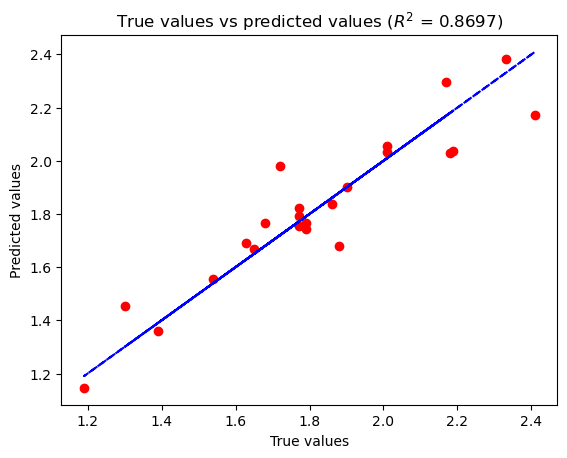

RMSE: 0.040801305349765615
r2: 0.8565603593889847


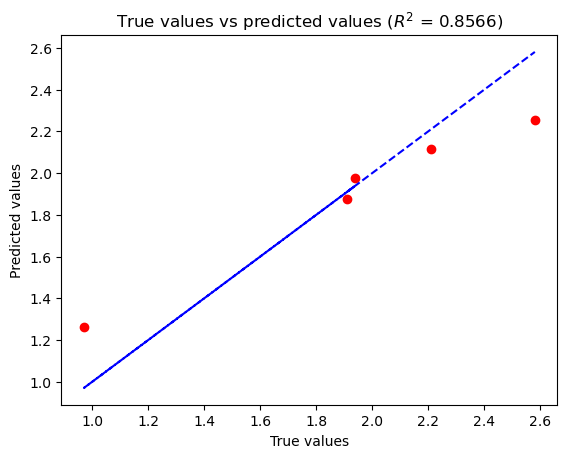

In [248]:
X_train_V, X_test_V, y_true_train, y_true_test = split_and_normalize(X_V, y_true)

lr_V = train_model(X_train_V, y_true_train) 
evaluate(lr_V, X_train_V, y_true_train, X_test_V, y_true_test)

## 文献中的方法





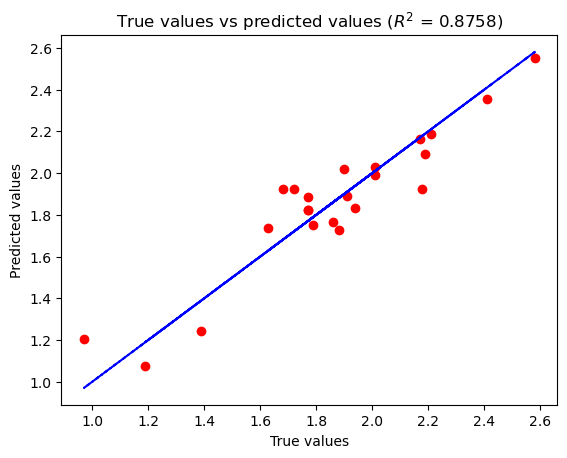

RMSE: 0.016019089634668675
r2: 0.8644540673891767


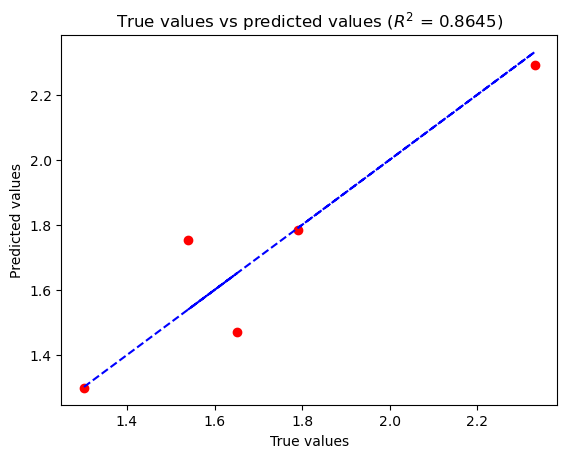

Model parameters: [-0.23043463  0.15471633 -0.15975213 -0.08517166]


In [206]:
# 从dataframe中选出这几列：['d_pi_w', 'B1_Alk', 'B5_Ar', 'de_pi_w']

X_article = X[['d_pi_w', 'B1_Alk', 'B5_Ar', 'de_pi_w']]

# 训练模型

X_article_train, X_article_test, y_true_train, y_true_test = split_and_normalize(X_article, y_true)

lr_article = LinearRegression()

model_article = train_model(X_article_train, y_true_train)

evaluate(model_article, X_article_train, y_true_train, X_article_test, y_true_test)

# 输出模型的参数

def get_model_params(model):
    params = model.coef_
    return params

params = get_model_params(model_article)
print(f"Model parameters: {params}")